In [131]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import linregress 
import requests
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [132]:
#Definitions
PEAK_AGE = 80

In [133]:
# Load the clean 2005 data CSV file into a Pandas DataFrame
clean_2005_DD_df = pd.read_csv("cleaned_data_csv_files/clean_output_2005_DD_df.csv", low_memory=False)

# Display sample data
print(clean_2005_DD_df.shape)
clean_2005_DD_df.head()

(1719615, 12)


,Death in United States 2005,detail_age,detail_age_type_text,sex_text,race_text,marital_status_text,day_of_week_of_death_text,month_of_death_text,place_of_death_and_decedents_status_text,manner_of_death_text,358_cause_recode_text,130_infant_cause_recode_text
0,0,45,Years,Female,White,Married,Monday,January,"Hospital, clinic or Medical Center",Natural,Malignant melanoma of skin (C43),NaN
1,1,61,Years,Male,White,Divorced,Saturday,January,"Hospital, clinic or Medical Center",Natural,Emphysema (J43),NaN
2,2,79,Years,Female,White,Divorced,Sunday,January,Nursing home/long term care,Natural,Other cerebrovascular diseases and their seque...,NaN
3,3,50,Years,Male,White,"Never married, single",Wednesday,January,"Hospital, clinic or Medical Center",Natural,Diabetes mellitus (E10-E14),NaN
4,4,68,Years,Female,White,Married,Monday,January,"Hospital, clinic or Medical Center",Natural,"Of trachea, bronchus and lung (C33-C34)",NaN


In [134]:
#Reset index to use patient data ID numbers from original CSV, not arbitrary index assignments
clean_2005_DD_df = clean_2005_DD_df.drop(columns=["Death in United States 2005"])
clean_2005_DD_df

,detail_age,detail_age_type_text,sex_text,race_text,marital_status_text,day_of_week_of_death_text,month_of_death_text,place_of_death_and_decedents_status_text,manner_of_death_text,358_cause_recode_text,130_infant_cause_recode_text
0,45,Years,Female,White,Married,Monday,January,"Hospital, clinic or Medical Center",Natural,Malignant melanoma of skin (C43),NaN
1,61,Years,Male,White,Divorced,Saturday,January,"Hospital, clinic or Medical Center",Natural,Emphysema (J43),NaN
2,79,Years,Female,White,Divorced,Sunday,January,Nursing home/long term care,Natural,Other cerebrovascular diseases and their seque...,NaN
3,50,Years,Male,White,"Never married, single",Wednesday,January,"Hospital, clinic or Medical Center",Natural,Diabetes mellitus (E10-E14),NaN
4,68,Years,Female,White,Married,Monday,January,"Hospital, clinic or Medical Center",Natural,"Of trachea, bronchus and lung (C33-C34)",NaN
...,...,...,...,...,...,...,...,...,...,...,...
1719610,47,Years,Male,White,Marital Status unknown,Saturday,December,Decedent’s home,Natural,"Atherosclerotic cardiovascular disease, so des...",NaN
1719611,78,Years,Female,White,"Never married, single",Monday,September,Decedent’s home,Natural,"Atherosclerotic cardiovascular disease, so des...",NaN
1719612,32,Years,Female,White,Marital Status unknown,Tuesday,December,Decedent’s home,Natural,Diabetes mellitus (E10-E14),NaN
1719613,70,Years,Male,Black,Marital Status unknown,Sunday,December,Decedent’s home,Natural,"Atherosclerotic cardiovascular disease, so des...",NaN


In [135]:
#Create a new dataframe that only includes the data for individuals with a cause of death related to heart disease
selected_entries_heart = ["All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)",
                    "Acute myocardial infarction (I21-I22)",
                    "Atherosclerotic cardiovascular disease, so described (I25.0)",
                    "Congestive heart failure (I50.0)"]

heart_disease_df = clean_2005_DD_df[clean_2005_DD_df["358_cause_recode_text"].isin(selected_entries_heart)]
heart_disease_df

,detail_age,detail_age_type_text,sex_text,race_text,marital_status_text,day_of_week_of_death_text,month_of_death_text,place_of_death_and_decedents_status_text,manner_of_death_text,358_cause_recode_text,130_infant_cause_recode_text
18,64,Years,Male,White,Divorced,Sunday,January,Other,Natural,"Atherosclerotic cardiovascular disease, so des...",NaN
58,63,Years,Male,White,Widowed,Friday,January,Decedent’s home,Natural,"Atherosclerotic cardiovascular disease, so des...",NaN
59,68,Years,Male,American Indian (includes Aleuts and Eskimos),"Never married, single",Saturday,January,Decedent’s home,Natural,"Atherosclerotic cardiovascular disease, so des...",NaN
65,81,Years,Female,White,Widowed,Saturday,January,Other,Natural,"Atherosclerotic cardiovascular disease, so des...",NaN
76,75,Years,Male,White,Married,Monday,January,"Hospital, clinic or Medical Center",Natural,All other forms of chronic ischemic heart dise...,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1719608,65,Years,Female,Black,Marital Status unknown,Monday,December,"Hospital, Clinic or Medical Center",Natural,"Atherosclerotic cardiovascular disease, so des...",NaN
1719610,47,Years,Male,White,Marital Status unknown,Saturday,December,Decedent’s home,Natural,"Atherosclerotic cardiovascular disease, so des...",NaN
1719611,78,Years,Female,White,"Never married, single",Monday,September,Decedent’s home,Natural,"Atherosclerotic cardiovascular disease, so des...",NaN
1719613,70,Years,Male,Black,Marital Status unknown,Sunday,December,Decedent’s home,Natural,"Atherosclerotic cardiovascular disease, so des...",NaN


In [185]:
#Determine the total number of deaths in 2005 due to heart disease
total_deaths_heart_disease = heart_disease_df.shape[0]
print("Total number of deaths in 2005 due to heart disease:", total_deaths_heart_disease)

Total number of deaths in 2005 due to heart disease: 346185


In [136]:
# Determine the number of heart disease deaths by sex
gender_count = heart_disease_df['sex_text']
male_count = len(heart_disease_df[heart_disease_df['sex_text'] == 'Male'])
female_count = len(heart_disease_df[heart_disease_df['sex_text'] == 'Female'])

print(f"Number of males in the DataFrame: {male_count}")
print(f"Number of females in the DataFrame: {female_count}")

Number of males in the DataFrame: 180368
Number of females in the DataFrame: 165817


In [137]:
# Describe the frequency of heart disease by age

# Mean
average_male_count = heart_disease_df.loc[heart_disease_df['sex_text'] == 'Male', 'detail_age'].mean()
average_female_count = heart_disease_df.loc[heart_disease_df['sex_text'] == 'Female', 'detail_age'].mean()

# Median
median_male_count = heart_disease_df.loc[heart_disease_df['sex_text'] == 'Male', 'detail_age'].median()
median_female_count = heart_disease_df.loc[heart_disease_df['sex_text'] == 'Female', 'detail_age'].median()

# Mode
mode_male_count = heart_disease_df.loc[heart_disease_df['sex_text'] == 'Male', 'detail_age'].mode()
mode_female_count = heart_disease_df.loc[heart_disease_df['sex_text'] == 'Female', 'detail_age'].mode()

print(f"Average count for males: {average_male_count}")
print(f"Median count for males: {median_male_count}")
print(f"Mode count for males: {mode_male_count}")
print (f"-----------------------------------------------")
print(f"Average count for females: {average_female_count}")
print(f"Median count for females: {median_female_count}")
print(f"Mode count for females: {mode_female_count}")

Average count for males: 73.60675951388274
Median count for males: 76.0
Mode count for males: 0    84
Name: detail_age, dtype: int64
-----------------------------------------------
Average count for females: 81.8883226689664
Median count for females: 84.0
Mode count for females: 0    87
Name: detail_age, dtype: int64


In [138]:
#Describe: mode vs mean very different for men, more similar for women
#t-test?

In [139]:
#Import csv file with age and sex data for 2005
census_2005_data_df = pd.read_csv("source_files/census_pop_data_2000_2010.csv", low_memory=False)
census_2005_data_df.head()

,REGION,DIVISION,STATE,NAME,SEX,AGE,ESTIMATESBASE2000,POPESTIMATE2000,POPESTIMATE2001,POPESTIMATE2002,POPESTIMATE2003,POPESTIMATE2004,POPESTIMATE2005,POPESTIMATE2006,POPESTIMATE2007,POPESTIMATE2008,POPESTIMATE2009,CENSUS2010POP,POPESTIMATE2010
0,0,0,0,United States,0,0,3805718,3855956,4012658,3951461,3975871,4014258,4004393,4041738,4147997,4132735,4003587,3944153,3952444
1,0,0,0,United States,0,1,3820647,3798691,3855407,4004674,3936139,3953063,3987032,3972124,4002215,4100756,4078797,3978070,3951024
2,0,0,0,United States,0,2,3790534,3800144,3800096,3856114,4002836,3933735,3952632,3988119,3973479,4004146,4103002,4096929,4087074
3,0,0,0,United States,0,3,3832855,3821118,3802710,3804336,3860727,4008220,3943215,3966022,4004011,3992320,4025675,4119040,4133855
4,0,0,0,United States,0,4,3926400,3902384,3827346,3812607,3816873,3876609,4030128,3970880,3998260,4041170,4033457,4063170,4076132


In [140]:
# Create dataframe showing age, sex, and population estimate for 2005
pop_data_2005_df = pd.DataFrame(census_2005_data_df, columns=["NAME", "AGE", "SEX", "POPESTIMATE2005"])
pop_data_2005_df.head()

,NAME,AGE,SEX,POPESTIMATE2005
0,United States,0,0,4004393
1,United States,1,0,3987032
2,United States,2,0,3952632
3,United States,3,0,3943215
4,United States,4,0,4030128


In [141]:
#Restrict the data to only the entries representing all US, to avoid duplication when county entries lsited by state
pop_data_2005_df = pop_data_2005_df[pop_data_2005_df["NAME"] == "United States"]
pop_data_2005_df.head()

,NAME,AGE,SEX,POPESTIMATE2005
0,United States,0,0,4004393
1,United States,1,0,3987032
2,United States,2,0,3952632
3,United States,3,0,3943215
4,United States,4,0,4030128


In [142]:
#Clean population dataset to remove individuals that do not identify as male or female
pop_data_2005_df = pop_data_2005_df[pop_data_2005_df["SEX"] != 0]
pop_data_2005_df.head()

,NAME,AGE,SEX,POPESTIMATE2005
87,United States,0,1,2047711
88,United States,1,1,2036538
89,United States,2,1,2020295
90,United States,3,1,2012820
91,United States,4,1,2058231


In [143]:
#Clean population data to remove entries where the age in unknown (defined as 999)
pop_data_2005_df = pop_data_2005_df[pop_data_2005_df["AGE"] != 999]
pop_data_2005_df.head()

,NAME,AGE,SEX,POPESTIMATE2005
87,United States,0,1,2047711
88,United States,1,1,2036538
89,United States,2,1,2020295
90,United States,3,1,2012820
91,United States,4,1,2058231


In [188]:
#Display the total population from the 2005 US Censue data for all age groups

# Calculate the total population for all ages in the DataFrame
total_population_all_ages = pop_data_2005_df['POPESTIMATE2005'].sum()

# Display the total population for all ages
print("Total Population for All Ages in 2005:", total_population_all_ages)

Total Population for All Ages in 2005: 295516599


In [189]:
#Determine the percentage of total population whose death was due to heart disease
overall_heart_disease_deaths = total_deaths_heart_disease / total_population_all_ages
overall_percentage_heart_disease_deaths = overall_heart_disease_deaths * 100

# Display the percentage of total population whose death was due to heart disease
print("Percentage of total US population in 2005 whose death was due to heart disease: {:.2f}%".format(overall_percentage_heart_disease_deaths))

Percentage of total US population in 2005 whose death was due to heart disease: 0.12%


In [145]:
# Create a mapping dictionary for sex
sex_mapping = {1: 'Male', 2: 'Female'}

# Map the values in the 'SEX' column using the mapping dictionary
pop_data_2005_df['SEX'] = pop_data_2005_df['SEX'].map(sex_mapping)

# Display the updated DataFrame
print(pop_data_2005_df)

              NAME  AGE     SEX  POPESTIMATE2005
87   United States    0    Male          2047711
88   United States    1    Male          2036538
89   United States    2    Male          2020295
90   United States    3    Male          2012820
91   United States    4    Male          2058231
..             ...  ...     ...              ...
255  United States   81  Female           742630
256  United States   82  Female           683339
257  United States   83  Female           648391
258  United States   84  Female           595097
259  United States   85  Female          3249455

[172 rows x 4 columns]


In [146]:
# #Group the data for each sex into 5 year timeframes (ages between 0 and 120), and calculate the population total for those age groups

# Create a new column to represent the ten-year time frame
pop_data_2005_df['Ten_Year_Frame'] = (pop_data_2005_df['AGE'] // 10) * 10

# Group the data by sex and ten-year intervals, and calculate the sum of "POPESTIMATE2005"
result = pop_data_2005_df.groupby(['SEX', 'Ten_Year_Frame'])['POPESTIMATE2005'].sum()

# Display the result showing the sum for males and females in each ten-year interval
print(result)

SEX     Ten_Year_Frame
Female  0                 19215705
        10                20783171
        20                19935350
        30                20246774
        40                22810811
        50                19265300
        60                12330051
        70                 9028325
        80                 6704034
Male    0                 20090762
        10                21915622
        20                20559315
        30                20275816
        40                22313245
        50                18316653
        60                11086853
        70                 7038354
        80                 3600458
Name: POPESTIMATE2005, dtype: int64


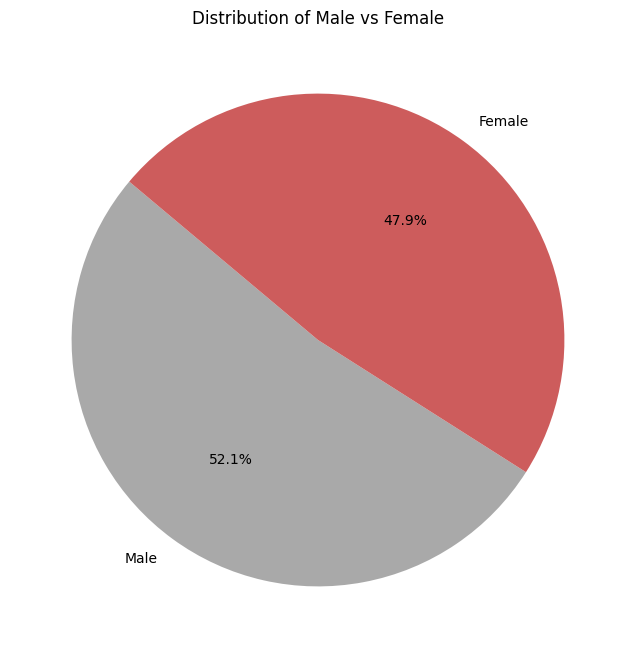

In [147]:
#Create a pie chart showing the percentage of male vs female patients whose caase of death was heart disease

# Filter out entries with age greater than 120 (Age Unknown populates as a number in the thousands)
filtered_df = heart_disease_df[heart_disease_df['detail_age'] <= 120]

# Define age groups for aggregation
# Create age bins of width 10
age_bins = np.arange(0, 121, 10)  

# Create a new column 'age_group' based on the age bins
filtered_df['age_group'] = pd.cut(filtered_df['detail_age'], bins=age_bins, labels=age_bins[:-1])

# Calculate the count of male and female
gender_counts = heart_disease_df['sex_text'].value_counts()

# Create a pie chart with males in grey and females in a shade of red
colors = ['darkgrey', 'indianred']  

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution of Male vs Female')
plt.show()

In [148]:
# Calculate the total number of women and men affected by heart disease
total_population_women = pop_data_2005_df.loc[pop_data_2005_df['SEX'] == 'Female', 'POPESTIMATE2005'].sum()
total_population_men = pop_data_2005_df.loc[pop_data_2005_df['SEX'] == 'Male', 'POPESTIMATE2005'].sum()

# Calculate the total number of women and men affected
total_women_affected = gender_counts['Female'] / 100 * total_population_women
total_men_affected = gender_counts['Male'] / 100 * total_population_men

# Display the total number of women and men affected
print(f"Total number of women affected by heart disease: {int(total_women_affected)}")
print(f"Total number of men affected by heart disease: {int(total_men_affected)}")

Total number of women affected by heart disease: 249255320136
Total number of men affected by heart disease: 261889065647


In [149]:
#Evalute the difference in males vs females dying of heart disease. Set up Chi-Squared analysis.

#Define groups to obtain data for males and females dying of heart disease
contingency_table = pd.crosstab(index=heart_disease_df["sex_text"], columns="count")
contingency_table

#Define observed data (from heart_disease_df)
observed = pd.Series([165817,180368], index=["Female", "Male"])

#Create a new dataframe
chi_sq_heart_disease = pd.DataFrame([observed]).T

#Add column with expected values (should be equal: (165817+180368)/2 = 173092.5
chi_sq_heart_disease[1] = 173092.5

#Rename columns
chi_sq_heart_disease.columns = ["observed", "expected"]

# The degree of freedom is 2-1 = 1
# With a p-value of 0.05, the confidence level is 1.00-0.05 = 0.95.
critical_value = stats.chi2.ppf(q = 0.95, df = 2)

print(f"Critical value: {(critical_value)}")

Critical value: 5.991464547107979


In [150]:
#Evalute the difference in males vs females dying of heart disease. Run the Chi-Squared analysis.

stats.chisquare(chi_sq_heart_disease['observed'], chi_sq_heart_disease['expected'])

Power_divergenceResult(statistic=611.6140242933692, pvalue=4.985356745005745e-135)

In [151]:
##Provide conclusions of Chi-Square

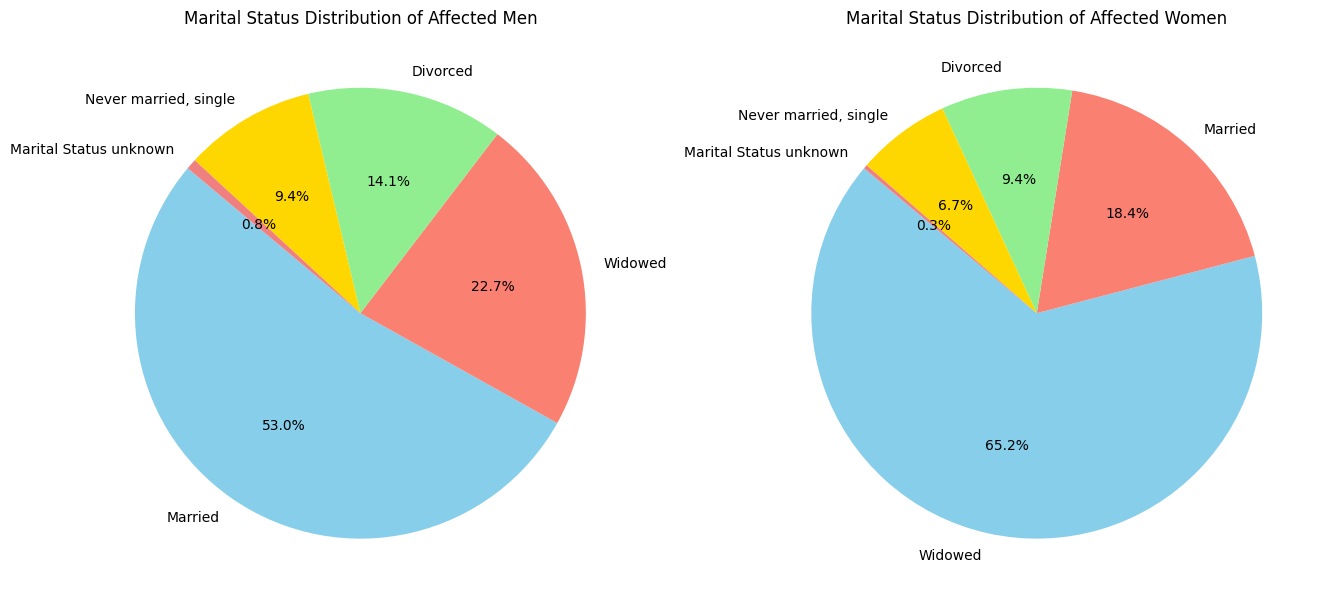

In [152]:
#Is there a relationship between the marital status of individuals and dying of heart disease?

# Filter for sex in the dataset
men_df = filtered_df[filtered_df['sex_text'] == 'Male']
women_df = filtered_df[filtered_df['sex_text'] == 'Female']

# Calculate the count of marital statuses for each sex
men_marital_counts = men_df['marital_status_text'].value_counts()
women_marital_counts = women_df['marital_status_text'].value_counts()

# Create pie charts, per sex, with different colors for each marital status
colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'lightcoral', 'lightskyblue', 'lightpink']

# Create subplots for male and female pie charts
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot pie chart for men
axs[0].pie(men_marital_counts, labels=men_marital_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
axs[0].set_title('Marital Status Distribution of Affected Men')

# Plot pie chart for women
axs[1].pie(women_marital_counts, labels=women_marital_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
axs[1].set_title('Marital Status Distribution of Affected Women')

plt.show()

In [153]:
##Desribe observations

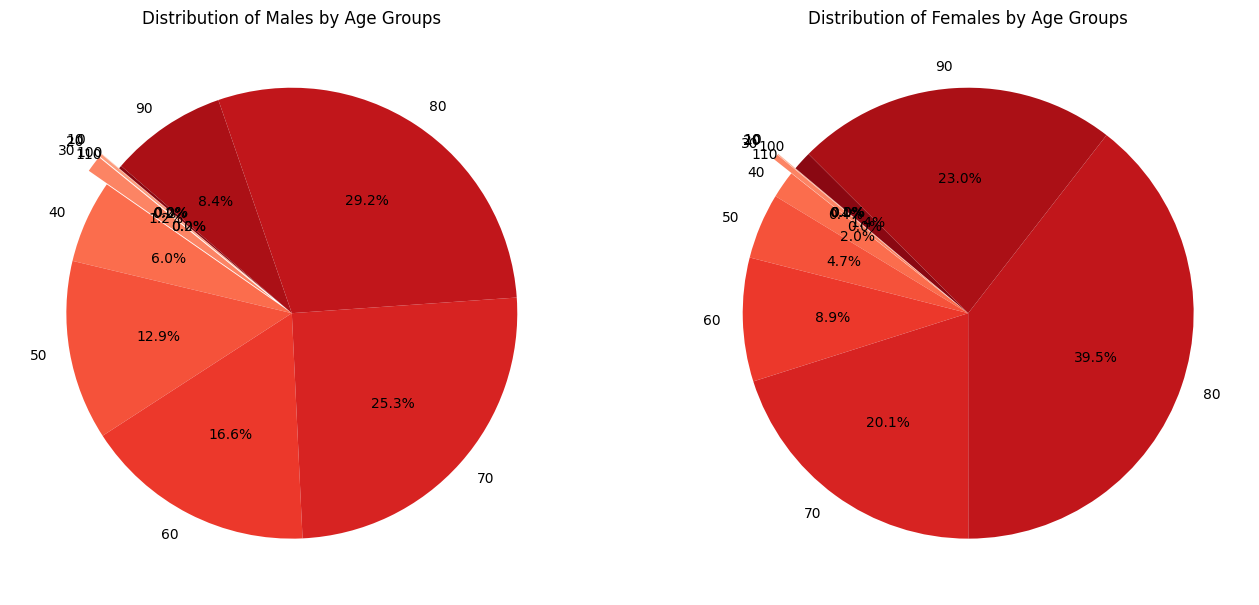

In [154]:
#Display the breakdown by age group for male or females deaths due to heart disease

# Calculate the count of male and female by age group
gender_counts_by_age = filtered_df.groupby(['sex_text', 'age_group']).size().unstack()

# Define colors for the pie charts based on a gradient of red, pink, white, and grey
colors = plt.cm.Reds(np.linspace(0.2, 1, len(gender_counts_by_age.columns)))

# Create two pie charts - one for males and one for females by age groups
explode = (0.1, 0.1, 0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Pie chart for males by age groups
wedges, texts, autotexts = axs[0].pie(gender_counts_by_age.loc['Male'], explode = explode, labels=gender_counts_by_age.columns, autopct='%1.1f%%', startangle=140, labeldistance=1.1, colors=colors)
axs[0].set_title('Distribution of Males by Age Groups')

# Pie chart for females by age groups
wedges, texts, autotexts = axs[1].pie(gender_counts_by_age.loc['Female'], explode = explode, labels=gender_counts_by_age.columns, autopct='%1.1f%%', startangle=140, labeldistance=1.1, colors=colors)
axs[1].set_title('Distribution of Females by Age Groups')

plt.show()

In [155]:
#Determine the total estimated deaths by age group for males and females

# Get the wedges from the pie chart
wedges, _, autotexts = axs[0].pie(gender_counts_by_age.loc['Male'], labels=gender_counts_by_age.columns, autopct='%1.1f%%', startangle=140, labeldistance=1.1)
wedges, _, autotexts = axs[0].pie(gender_counts_by_age.loc['Female'], labels=gender_counts_by_age.columns, autopct='%1.1f%%', startangle=140, labeldistance=1.1)

# Extract the displayed percentages from the autotexts
male_displayed_percentages = [float(autotext.get_text().strip('%')) for autotext in autotexts]
female_displayed_percentages = [float(autotext.get_text().strip('%')) for autotext in autotexts]

# Print the extracted percentages
print("Displayed Percentages from the Male Pie Chart:")
print(male_displayed_percentages)
print(f"----------------------------------------")
print("Displayed Percentages from the Feale Pie Chart:")
print(female_displayed_percentages)

Displayed Percentages from the Male Pie Chart:
[0.0, 0.0, 0.1, 0.4, 2.0, 4.7, 8.9, 20.1, 39.5, 23.0, 1.4, 0.0]
----------------------------------------
Displayed Percentages from the Feale Pie Chart:
[0.0, 0.0, 0.1, 0.4, 2.0, 4.7, 8.9, 20.1, 39.5, 23.0, 1.4, 0.0]


In [192]:
#Determine rate of death by age group

# # Calculate the total number of deaths per age group
# deaths_per_age_group = filtered_df.groupby('age_group')['number_of_deaths'].sum().reset_index()

# #Calculate the total population per age group from the pop_data_2005_df dataframe
# total_population_per_age_group = pop_data_2005_df.groupby('AGE')['POPESTIMATE2005'].sum().reset_index()

# #Merge the two datasets based on the age group
# merged_age_group_data = pd.merge(deaths_per_age_group, total_population_per_age_group, on='age_group', how='inner')

# Merge the total population per age group with the total number of deaths per age group
merged_age_group_data = pd.merge(total_population_per_age_group, deaths_per_age_group, left_on='AGE', right_on='age_group')

# Calculate the death rate per 100 people for each age group
merged_age_group_data['death_rate_per_100'] = (merged_age_group_data['number_of_deaths'] / merged_age_group)data['POPESTIMATE2005']) * 100

# Display the DataFrame with the death rate per 100 people for each age group
print(merged_age_group_data)

SyntaxError: unmatched ')' (625034818.py, line 16)

In [ ]:
#Determine if a signficant difference exists between age groups for all individuals dying from heart disease

In [156]:
# Calculate the total number of deaths per age group for males and females
total_deaths_by_age_group_male = {}
total_deaths_by_age_group_female = {}

for idx, age_group in enumerate(gender_counts_by_age.columns):
    total_deaths_by_age_group_male[age_group] = male_displayed_percentages[idx] / 100 * total_men_affected
    total_deaths_by_age_group_female[age_group] = female_displayed_percentages[idx] / 100 * total_women_affected

# Display the total number of deaths per age group for males and females
print("Total number of deaths per age group for males:")
for age_group, total_deaths in total_deaths_by_age_group_male.items():
    print(f"Age Group: {age_group}, Total Deaths: {int(total_deaths)}")

print("\nTotal number of deaths per age group for females:")
for age_group, total_deaths in total_deaths_by_age_group_female.items():
    print(f"Age Group: {age_group}, Total Deaths: {int(total_deaths)}")

Total number of deaths per age group for males:
Age Group: 0, Total Deaths: 0
Age Group: 10, Total Deaths: 0
Age Group: 20, Total Deaths: 261889065
Age Group: 30, Total Deaths: 1047556262
Age Group: 40, Total Deaths: 5237781312
Age Group: 50, Total Deaths: 12308786085
Age Group: 60, Total Deaths: 23308126842
Age Group: 70, Total Deaths: 52639702195
Age Group: 80, Total Deaths: 103446180930
Age Group: 90, Total Deaths: 60234485098
Age Group: 100, Total Deaths: 3666446919
Age Group: 110, Total Deaths: 0

Total number of deaths per age group for females:
Age Group: 0, Total Deaths: 0
Age Group: 10, Total Deaths: 0
Age Group: 20, Total Deaths: 249255320
Age Group: 30, Total Deaths: 997021280
Age Group: 40, Total Deaths: 4985106402
Age Group: 50, Total Deaths: 11715000046
Age Group: 60, Total Deaths: 22183723492
Age Group: 70, Total Deaths: 50100319347
Age Group: 80, Total Deaths: 98455851453
Age Group: 90, Total Deaths: 57328723631
Age Group: 100, Total Deaths: 3489574481
Age Group: 110, T

In [ ]:
#Work on cell below

In [ ]:
# Extract individual groups based on gender and age group counts
group_male = gender_counts_by_age.loc['Male']
group_female = gender_counts_by_age.loc['Female']

# Perform ANOVA test using the counts of males and females by age group
from scipy.stats import f_oneway

# Perform ANOVA test
f_statistic, p_value = f_oneway(group_male, group_female)

# Display the ANOVA results
print("ANOVA Results:")
print(f"F-Statistic: {f_statistic}")
print(f"P-Value: {p_value}")

# Check if the difference is statistically significant
alpha = 0.05
if p_value < alpha:
    print("The difference between male and female counts by age group is statistically significant.")
else:
    print("The difference between male and female counts by age group is not statistically significant.")

In [157]:
#Determine if the difference between males and females is statistically significant
#use t-test

In [158]:
#Use this cell to describe findings

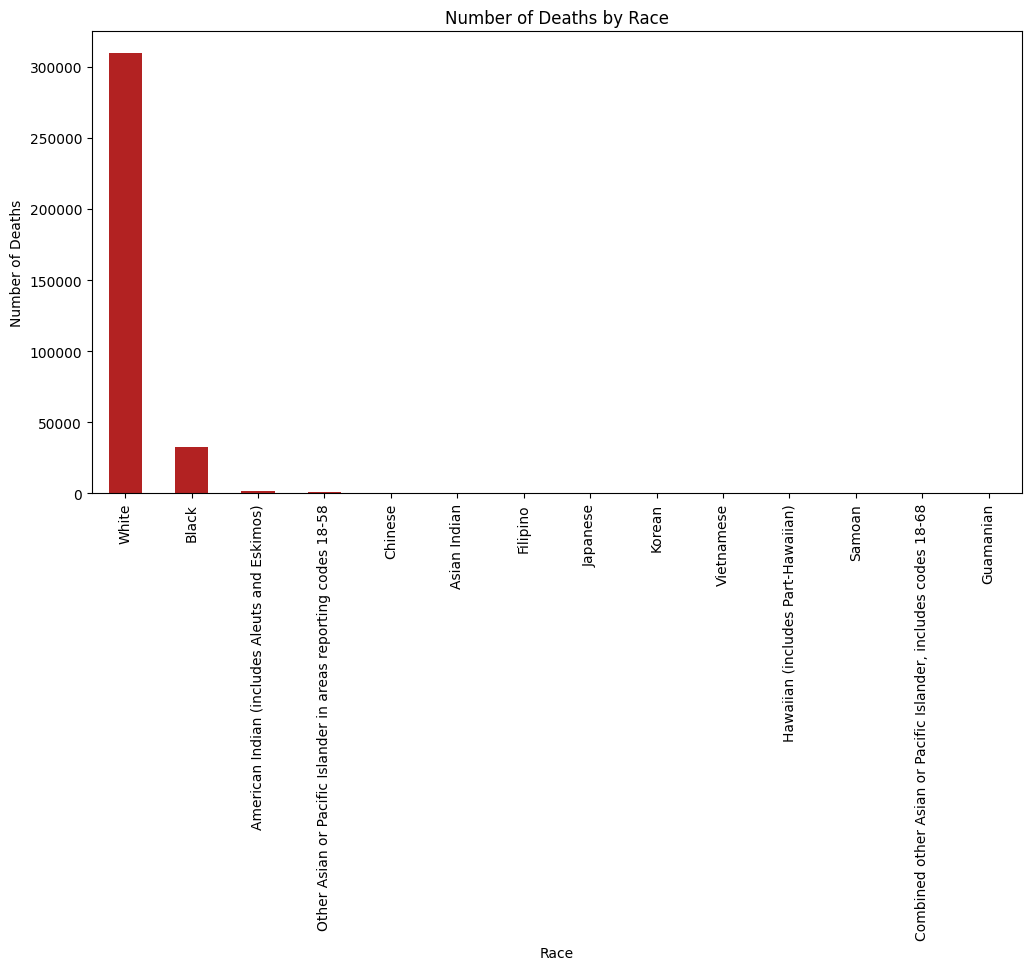

In [159]:
# Create a histogram of deaths due to heart disease by race

plt.figure(figsize=(12, 6))
heart_disease_df['race_text'].value_counts().plot(kind='bar', color='firebrick')
plt.title('Number of Deaths by Race')
plt.xlabel('Race')
plt.ylabel('Number of Deaths')
plt.xticks(rotation=90)
plt.show()

In [160]:
#Determine if the difference between males and females is statistically significant
#use ANOVA test

In [161]:
#Use this cell to describe findings

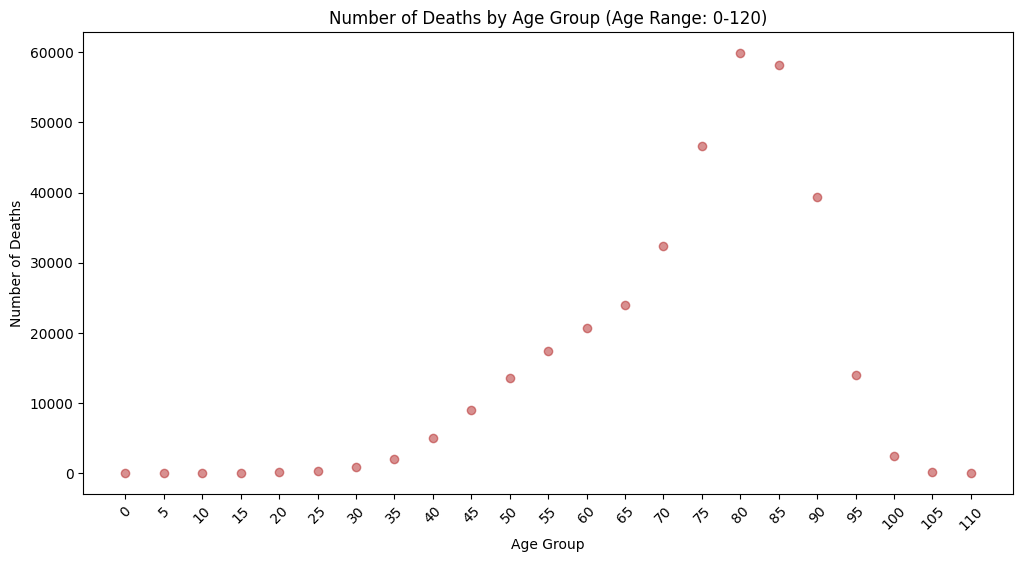

In [162]:
# Create a scatter plot of deaths by age

#Define data points every 5 years to provide more data points for plotting

# Adjust the age group calculation to group data by 5-year intervals
filtered_df["age_group"] = ((filtered_df["detail_age"] - 1) // 5) * 5

# Group by age group and count the number of deaths in each group
age_group_counts = filtered_df.groupby("age_group").size()

# Convert age_group_counts index to numeric
age_group_counts.index = pd.to_numeric(age_group_counts.index)

# Create a scatter plot of deaths by age group
plt.figure(figsize=(12, 6))
plt.scatter(age_group_counts.index, age_group_counts, color="firebrick", alpha=0.5)
plt.title("Number of Deaths by Age Group (Age Range: 0-120)")
plt.xlabel("Age Group")
plt.ylabel("Number of Deaths")
plt.xticks(age_group_counts.index, rotation=45)
plt.show()

R-squared value: 0.21592095183996315


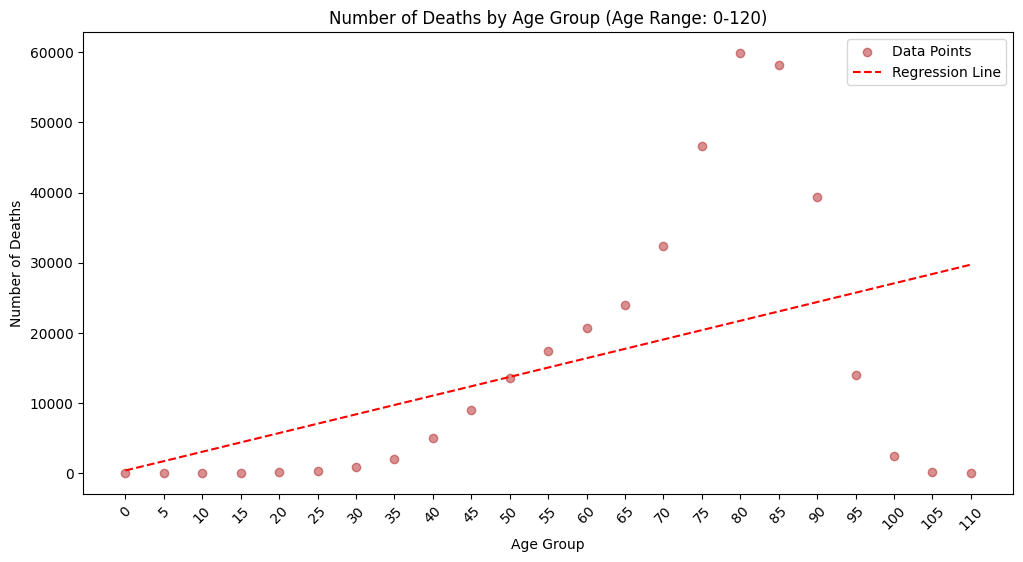

In [163]:
#Determine if there is a relationship between age and death due to heart disease using linear regression analysis

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(age_group_counts.index, age_group_counts)
regression_line = slope * age_group_counts.index + intercept

# Calculate R-squared value
r_squared = r_value ** 2
print(f"R-squared value: {r_squared}")

# Create a scatter plot of deaths by age group
plt.figure(figsize=(12, 6))
plt.scatter(age_group_counts.index, age_group_counts, color='firebrick', alpha=0.5, label='Data Points')
plt.plot(age_group_counts.index, regression_line, color='red', linestyle='--', label='Regression Line')
plt.title('Number of Deaths by Age Group (Age Range: 0-120)')
plt.xlabel('Age Group')
plt.ylabel('Number of Deaths')
plt.xticks(age_group_counts.index, rotation=45)
plt.legend()
plt.show()

In [164]:
# Men and Women deaths in individuals over 80
deaths_over80_male = heart_disease_df[(heart_disease_df['detail_age'] >= 81) & (heart_disease_df['sex_text'] == 'Male') ]
deaths_over80_female = heart_disease_df[(heart_disease_df['detail_age'] >= 81) & (heart_disease_df['sex_text'] == 'Female') ]

num_deaths_over80_male = len(deaths_over80_male)
num_deaths_over80_female = len(deaths_over80_female)

print(f"Number of deaths due to heart disease for males over age 80: {num_deaths_over80_male}")
print(f"Number of deaths due to heart disease for females over age 80: {num_deaths_over80_female}")

Number of deaths due to heart disease for males over age 80: 68160
Number of deaths due to heart disease for females over age 80: 105925


In [165]:
#Calculate any statistical difference between men and women over age 80
#use t-test

In [166]:
#Enter discussion of the shape of the curve and deciding to remove the age group > 80

In [167]:
# Define an exponential function for curve fitting betwen ages 0 and 80
def inc_exponential_death(age, a, b, c):
    y_increase = a * np.exp(b * (age-PEAK_AGE)) + c
    return y_increase 

In [168]:
#Define separate populations (increasing curve up to age 80, decreasing curve afterwards)
age_group_counts_leq_peak = age_group_counts[age_group_counts.index <= PEAK_AGE]
#age_group_counts_geq_peak = age_group_counts[age_group_counts.index >= PEAK_AGE]

The R-squared value is: -818166.3726802832


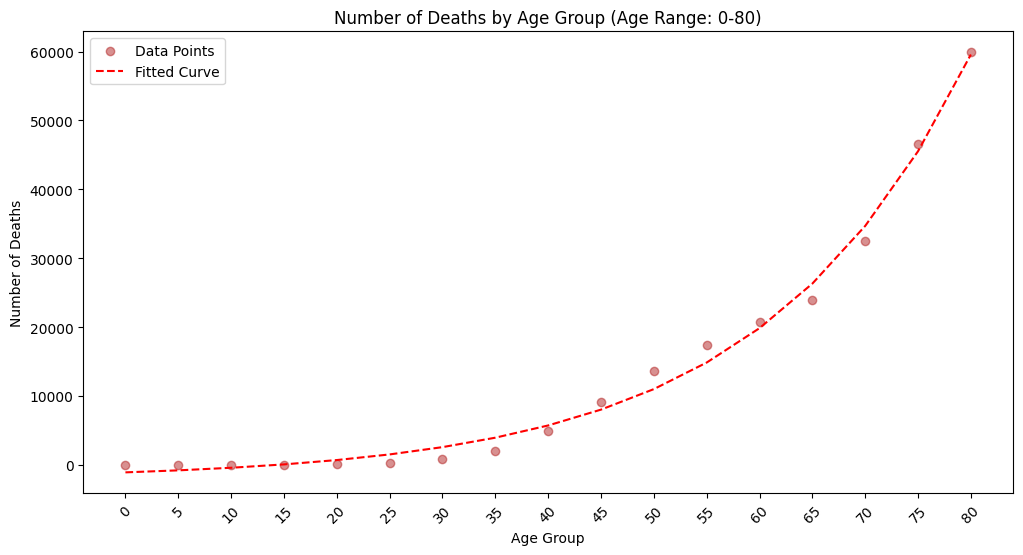

In [169]:
#Determine if there is a relationship between age and death due to heart disease using curvilinear regression analysis up to age 80

# Perform curvilinear regression (AKA curve fitting) 
popt, pcov = curve_fit(inc_exponential_death, age_group_counts_leq_peak.index, age_group_counts_leq_peak.values)

#Calculate the R-squared value
y_pred_leq = inc_exponential_death(age_group_counts_leq_peak.index, *popt)
r_squared = r2_score(age_group_counts_leq_peak.index, y_pred_leq)
print(f"The R-squared value is: {r_squared}")

# Create a scatter plot of deaths by age group
plt.figure(figsize=(12, 6))
plt.scatter(age_group_counts_leq_peak.index, age_group_counts_leq_peak, color='firebrick', alpha=0.5, label='Data Points')
plt.plot(age_group_counts_leq_peak.index, inc_exponential_death(age_group_counts_leq_peak.index, *popt), color='red', linestyle='--', label='Fitted Curve')
plt.title('Number of Deaths by Age Group (Age Range: 0-80)')
plt.xlabel('Age Group')
plt.ylabel('Number of Deaths')
plt.xticks(age_group_counts_leq_peak.index, rotation=45)
plt.legend()
plt.annotate(popt, (0, 100000), color='red')
plt.show()

In [170]:
# Define an exponential function for curve fitting betwen ages 0 and 80
def dec_exponential_death(age, d, f, g):
    y_decrease = d * np.exp(f * (PEAK_AGE-age)) + g
    return y_decrease 

In [171]:
#Define separate populations (increasing curve up to age 80, decreasing curve afterwards)
age_group_counts_geq_peak = age_group_counts[age_group_counts.index >= PEAK_AGE]

The R-squared value is: -11965841.711591134


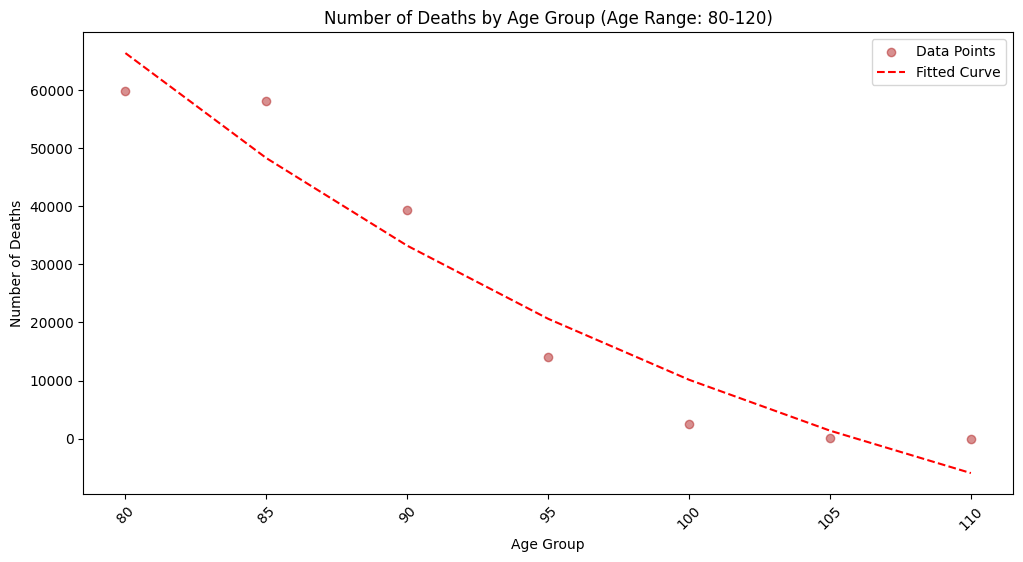

In [172]:
#Determine if there is a relationship between age and death due to heart disease using curvilinear regression analysis up to age 80

# Perform curvilinear regression (AKA curve fitting) 
popt, pcov = curve_fit(dec_exponential_death, age_group_counts_geq_peak.index, age_group_counts_geq_peak.values)

#Calculate the R-squared value
y_pred_geq = dec_exponential_death(age_group_counts_geq_peak.index, *popt)
r_squared = r2_score(age_group_counts_geq_peak.index, y_pred_geq)
print(f"The R-squared value is: {r_squared}")

# Create a scatter plot of deaths by age group
plt.figure(figsize=(12, 6))
plt.scatter(age_group_counts_geq_peak.index, age_group_counts_geq_peak, color='firebrick', alpha=0.5, label='Data Points')
plt.plot(age_group_counts_geq_peak.index, dec_exponential_death(age_group_counts_geq_peak.index, *popt), color='red', linestyle='--', label='Fitted Curve')
plt.title('Number of Deaths by Age Group (Age Range: 80-120)')
plt.xlabel('Age Group')
plt.ylabel('Number of Deaths')
plt.xticks(age_group_counts_geq_peak.index, rotation=45)
plt.legend()
plt.annotate(popt, (0, 100000), color='red')
plt.show()

In [173]:
#Describe the relationship

In [174]:
#Evaluate differences in the trend in males vs females between 0-80 and 80-120

# Filter the data for Males and age between 0 and 80
male_heart_data = heart_disease_df[(heart_disease_df['sex_text'] == 'Male') & (heart_disease_df['detail_age'] >= 0) & (heart_disease_df['detail_age'] <= 80)]
female_heart_data = heart_disease_df[(heart_disease_df['sex_text'] == 'Female') & (heart_disease_df['detail_age'] >= 0) & (heart_disease_df['detail_age'] <= 80)]




In [175]:
#Use this cell to describe findings

In [176]:
#Where do individuals with heart diease die?

In [177]:
#Are there differences between location for male vs female?

In [178]:
#Are there differences between location by age group?

In [179]:
#Describe any relationships statistically
#use ANOVA

In [180]:
#What is the nature of the individuals dying from heart disease (natural vs suicide vs homicide, etc)

In [181]:
#Are there any differences by sex?

In [182]:
#Are there any differences by age group?

In [183]:
#Describe any relationships statistically
#use ANOVA